In [1]:
import os

import numpy as np

import pandas as pd

from sklearn.datasets import load_svmlight_file
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from xgboost import XGBClassifier


from models import Simple_NN, MCDropout_NN, Ensemble_NN, RandomForestEntropy, GaussProcess, KNearest, ScaledSVC
from utils import *

plt.rcParams.update({'font.size': 12})

In [2]:
data_folder = './data/'
file_paths = [os.path.join(data_folder, 'batch{}.dat'.format(n)) for n in range(1,11)]

In [3]:
all_X = None
all_y = None

for i, path in enumerate(file_paths):
    X, y = load_svmlight_file(file_paths[i], dtype=np.float32)
    X = pd.DataFrame(X.toarray())
    X["batch"] = i
    y = pd.Series(y)
    all_X = pd.concat([all_X, X])
    all_y = pd.concat([all_y, y])

all_y = all_y - 1

##################

# Paste below training code when training with all features
# np.argsort(models["Random Forest (100)"].feature_importances_)[0:10]
# models["Random Forest (100)"].feature_importances_

# All features below
#np.arange(0, 129, 1).tolist()

feature_columns = [62, 102,  94, 127, 124,  46,  93, 119, 111,  92, 128]

def get_datasets(X, y, val_size=0.5, stratify=True, train_on=[0, 1], feature_columns=feature_columns):
    train_mask = np.zeros(all_X.shape[0]).astype(np.bool)
    for batch_id in train_on:
        train_mask = np.logical_or(train_mask, all_X["batch"] == batch_id)

    test_mask = np.zeros(all_X.shape[0]).astype(np.bool)
    for i in range(len(file_paths)):
        if i not in train_on:
            test_mask = np.logical_or(test_mask, all_X["batch"] == i)


    # X = all_X[train_mask].drop("batch", axis=1)
    X = all_X[train_mask].iloc[:, feature_columns]
    y = all_y[train_mask]

    if stratify:
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, stratify=y)
    else:
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size)

    X_test = all_X[test_mask].iloc[:, feature_columns]
    y_test = all_y[test_mask]

    y_train = y_train.astype(np.int)
    y_val = y_val.astype(np.int)
    y_test = y_test.astype(np.int)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [4]:
models = {
    "Decision Tree": {
        "model": DecisionTreeClassifier,
        "args": {}
    },
    "Random Forest (100)": {
        "model": RandomForestClassifier,
        "args": {
            "n_estimators": 100
        },
    },
    "XGBoost": {
        "model": XGBClassifier,
        "args": {
            "eval_metric": "mlogloss",
            "use_label_encoder": False
        }
    },
    "KNeighbors": {
        "model": KNearest,
        "args": {}
    },
    "SVM": {
        "model": ScaledSVC,
        "args": {
            
        }
    },
    "FCNN": {
        "model": Simple_NN,
        "args": {
            "input_features": len(feature_columns)-1,
        }
    },
    "MC Dropout (20)": 
    {
        "model": MCDropout_NN,
        "args": {
            "num_passes": 20, 
            "input_features": len(feature_columns)-1
        }
    },
    "Ensemble (10)": 
    {
        "model": Ensemble_NN,
        "args": {
            "num_nets": 10,
            "input_features": len(feature_columns)-1
        }
    },
}

n_runs = 10

model_runs = {key: [] for key in models}

validation_X = []
validation_y = []

### Train all models with the specified number of splits
for i in range(n_runs):
    # Shuffle and split data
    X_train, X_val, _, y_train, y_val, _ = get_datasets(all_X, all_y)
    validation_X.append(X_val)
    validation_y.append(y_val)
    for name, config in models.items():
        # Train model
        current_model = config["model"](**config["args"])
        current_model.fit(X_train.drop("batch", axis=1), y_train)
        model_runs[name].append(current_model)
        print("{} ({} of {}) - Val Accuracy is: {}".format(name, i + 1, n_runs, accuracy_score(y_val, current_model.predict(X_val.drop("batch", axis=1)))))

Decision Tree (1 of 10) - Val Accuracy is: 0.8792899408284024
Random Forest (100) (1 of 10) - Val Accuracy is: 0.936094674556213
XGBoost (1 of 10) - Val Accuracy is: 0.9337278106508876
KNeighbors (1 of 10) - Val Accuracy is: 0.927810650887574
SVM (1 of 10) - Val Accuracy is: 0.8449704142011835
FCNN (1 of 10) - Val Accuracy is: 0.9218934911242603
MC Dropout (20) (1 of 10) - Val Accuracy is: 0.9100591715976332
Ensemble (10) (1 of 10) - Val Accuracy is: 0.9467455621301775
Decision Tree (2 of 10) - Val Accuracy is: 0.8402366863905325
Random Forest (100) (2 of 10) - Val Accuracy is: 0.9266272189349113
XGBoost (2 of 10) - Val Accuracy is: 0.901775147928994
KNeighbors (2 of 10) - Val Accuracy is: 0.9230769230769231
SVM (2 of 10) - Val Accuracy is: 0.8142011834319527
FCNN (2 of 10) - Val Accuracy is: 0.9242603550295858
MC Dropout (20) (2 of 10) - Val Accuracy is: 0.9337278106508876
Ensemble (10) (2 of 10) - Val Accuracy is: 0.9301775147928995
Decision Tree (3 of 10) - Val Accuracy is: 0.847337

In [5]:
### Test all the models
_, _, X_test, _, _, y_test = get_datasets(all_X, all_y)
validation_X = [X_val.drop("batch", axis=1) for X_val in validation_X]

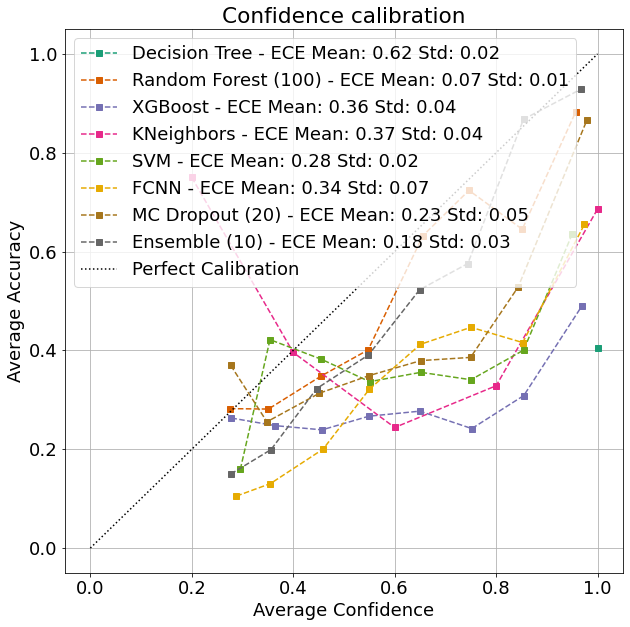

In [6]:
plot_calibration_curve(model_runs, X_test.drop('batch', axis=1), y_test)

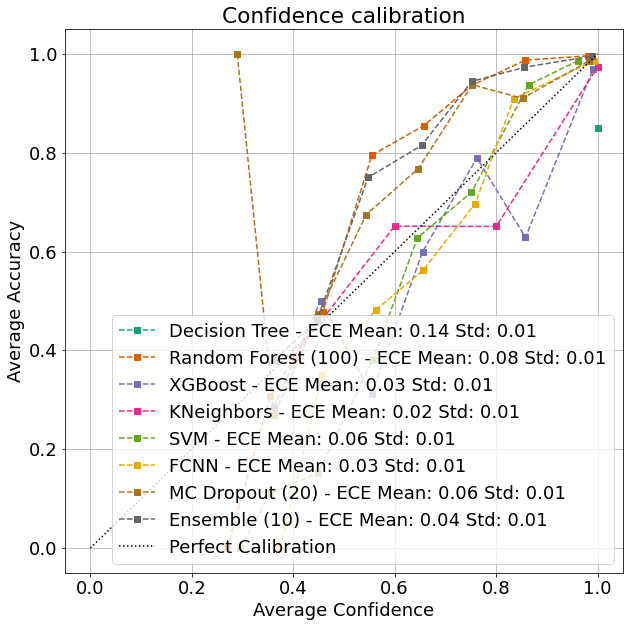

In [7]:
plot_calibration_curve(model_runs, validation_X, validation_y)

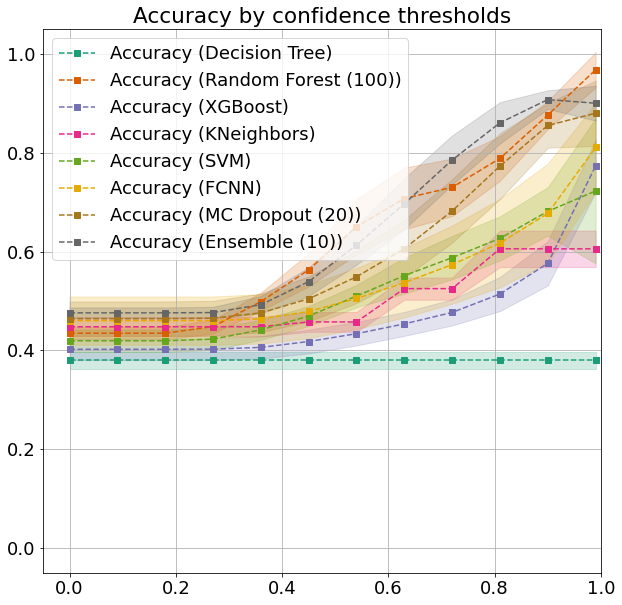

In [8]:
plot_accuracy_over_confidence_thresholds(model_runs, X_test.drop('batch', axis=1), y_test)

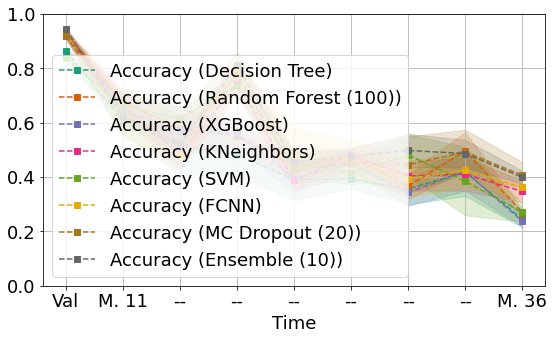

In [9]:
plot_over_batches(model_runs, X_test, y_test, batch_start=2, batch_end=10, X_val=validation_X, y_val=validation_y, plot_accuracy=True, start_label="M. 11", stop_label="M. 36", savename="accuracy_decrease.svg")

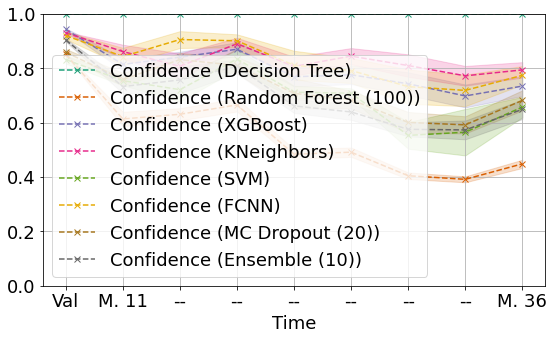

In [10]:
plot_over_batches(model_runs, X_test, y_test, batch_start=2, batch_end=10, X_val=validation_X, y_val=validation_y, plot_confidence=True, start_label="M. 11", stop_label="M. 36", savename="confidence_decrease.svg")

<Figure size 648x360 with 0 Axes>

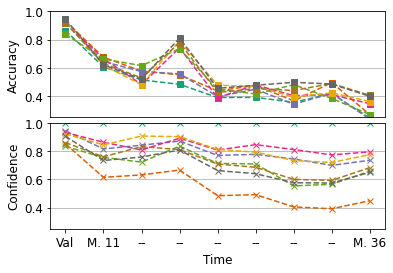

In [85]:
plot_accuracy_and_confidence(model_runs, X_test, y_test, batch_start=2, batch_end=10, X_val=validation_X, y_val=validation_y, start_label="M. 11", stop_label="M. 36", savename="accuracy_decrease.svg", legend=False)

In [49]:
models_runs_test = {
    "SVM": [model_runs["Random Forest (100)"][0]],
    "DT": [model_runs["Random Forest (100)"][0]],
    "KNN": [model_runs["Random Forest (100)"][0]],
    "RF": [model_runs["Random Forest (100)"][0]],
    "NN": [model_runs["Random Forest (100)"][0]],
    "NN-Ens": [model_runs["Random Forest (100)"][0]],
    "NN-MCD": [model_runs["Random Forest (100)"][0]],
}

In [ ]:
def plot_ece(models, X_val, y_val, X_test, y_test):
    